In [9]:
import sys
sys.path.append('../')

# En la siguiente línea se tiene que agregar el directorio donde está instalado dynaconf y simanneal
# (esto es sólo en caso de que python no lo encuentre automáticamente)
# sys.path.append('/Users/Marco/miniconda3/envs/dpa-rita/lib/python3.8/site-packages')
# sys.path.append('/usr/local/lib/python3.7/site-packages/simanneal')
# sys.path.append('/usr/local/lib/python3.7/site-packages')

from models import particle_swarm as ps
from models import simulated_annealing as sa
import Control as ctl
import Utileria as ut

# Pipeline del proyecto

A continuación se mostrará el pipeline del proyecto, desde que se crean las tablas para mostrar la información, hasta que el llenado de la tabla de resultados.

Para llevar a cabo el pipeline de todo el flujo, se crea una clase control desde la cual se mandarán a llamar a las funciones principales para:
-El cargado de la base

-La transformación de datos al formato adecuado de procesamiento

-El procesamiento de las rutas por cada fuerza de ventas

In [10]:
objControl = ctl.Control()

# Mediante esta variable, se controla el tipo de ejecución a realizar:
# objControl.str_TipoEjecucion = 'DEMO'
objControl.str_TipoEjecucion = 'REAL'

# Carga Inicial

Mediante el siguiente método, sucederá lo siguiente:

-Creación de esquemas

-Creación de tablas

-Creación de vistas

-Carga de información raw (fuerzas de ventas y catálogo de nodos)

-Se eliminarán tablas temporales auxiliares empleadas al momento de la cárga de nodos

In [11]:
%%time
objControl.CargarBase()

./sql/create_schemas.sql
./sql/create_tables.sql
./sql/create_views.sql
./sql/clean_tables.sql
CPU times: user 507 ms, sys: 289 ms, total: 796 ms
Wall time: 1min 1s


A continuación se pueden ver las 2 tablas cargadas, fuerza de ventas y el catálogo de ubicaciones de nodos

In [16]:
ut.get_data('select * from raw.fuerza_ventas limit 100;')

,fza_ventas,no_cliente,lat_destino,lon_destino,id_origen,estado,lat_origen,lon_origen
0,123,10295095,25.78480559,-100.39811999999999,11388,Nuevo León,25.7789,-100.387
1,123,1010290203,25.78390292,-100.3945131,11388,Nuevo León,25.7789,-100.387
2,123,1010290279,25.77787843,-100.4000348,11388,Nuevo León,25.7789,-100.387
3,123,1010291206,25.7624079,-100.39534990000001,11388,Nuevo León,25.7789,-100.387
4,123,1010291416,25.77327423,-100.40975909999999,11388,Nuevo León,25.7789,-100.387
...,...,...,...,...,...,...,...,...
95,3657,1007240657,25.6568298,-100.3199281,11140,Nuevo León,25.6631,-100.29700000000001
96,3657,1007241980,25.6617194,-100.32240279999999,11140,Nuevo León,25.6631,-100.29700000000001
97,3657,1007244274,25.65930749,-100.3273348,11140,Nuevo León,25.6631,-100.29700000000001
98,3657,1011230133,25.6595228,-100.32182320000001,11140,Nuevo León,25.6631,-100.29700000000001


In [17]:
ut.get_data('select * from trabajo.nodos limit 100;')

,nodo,lat,lon
0,10295095,25.78480559,-100.39811999999999
1,1010290203,25.78390292,-100.3945131
2,1010290279,25.77787843,-100.4000348
3,1010291206,25.7624079,-100.39534990000001
4,1010291416,25.77327423,-100.40975909999999
...,...,...,...
95,1007240657,25.6568298,-100.3199281
96,1007241980,25.6617194,-100.32240279999999
97,1007244274,25.65930749,-100.3273348
98,1011230133,25.6595228,-100.32182320000001


# Transormación de datos

Mediante el siguiente método, se transformará la información en crudo (raw) a una representación óptima de los grafos de conexión de cada empleado:

In [15]:
%%time
objControl.Transform()

copy trabajo.grafos from STDIN CSV HEADER QUOTE '"'
Loaded data into trabajo.grafos
CPU times: user 12min, sys: 7.76 s, total: 12min 8s
Wall time: 18min 25s


A continuación, se puede visualizar el resultado de la transformación de datos:

In [18]:
ut.get_data('select * from trabajo.grafos limit 100;')

,id_fza_ventas,id_origen,id_destino,distancia
0,22146,11564,605172,3.2922230290946053
1,22146,11564,65748852,4.057986797259037
2,22146,11564,1004600078,1.4796864251640178
3,22146,11564,1004600282,3.1928069376465626
4,22146,11564,1004603063,1.8907456870556614
...,...,...,...,...
95,22146,1004600078,1020258284,2.5765487573380765
96,22146,1004600078,1020286844,2.9805935512542363
97,22146,1004600078,1020300582,0.7853177022829883
98,22146,1004600078,1020357293,2.607150870458228


# Cálculo de rutas

## Particle Swarm secuencial
A partir de este momento, se puede comenzar a realizar el cálculo de rutas para todas las fuerzas de venta.

Primero se empleará el algoritmo de Particle Swarm de manera secuencial para medir el tiempo, y posteriormente en paralelo para comparar los tiempos de ejecución.

In [8]:
%%time
objControl.CalcularRutasSeq(ps.ParticleSwarm, objControl.dict_Hiper_PS)

--fza_ventas:  80993
--fza_ventas:  5074
--fza_ventas:  3216
--fza_ventas:  8430
--fza_ventas:  5623
--fza_ventas:  1143
--fza_ventas:  1342
--fza_ventas:  6922
--fza_ventas:  4848
--fza_ventas:  123
--fza_ventas:  3657
--fza_ventas:  8099
CPU times: user 261 ms, sys: 43.7 ms, total: 304 ms
Wall time: 26.9 s


Como se puede apreciar, el tiempo total del procesamiento secuencial fue de alrededor de: 

-24 segundos para ejecucion DEMO

-40 minutos para ejecucion REAL

Se eliminarán los registros que previamente fueron cargados para volver a realizar la carga pero ahora en paralelo:

In [24]:
conn = ut.CrearConexionRDS()
ut.EjecutarQuery(conn,'delete from trabajo.resultados;')

-1

## Particle Swarm paralelo

A continuación se ejecuta el método para calcular las rutas en paralelo. Para llevar a cabo la paralelización se empleo la librería de Dask. Esta librería ofrece opciones para paralelizar cálculos sobre arreglos de manera directa, sin embargo en nuestro caso se necesitaban paralelizar procesos como tal. Afortunadamente Dask ofrece un mecanismo para poder paralelizar cualquier función que alguien desee mediante el uso del decorador @dask.delayed, el uso de este decorador hará que la función decorada se convierta en una función "lazy", lo cual permitirá apilar o juntar varias funciones de tal manera que uno mismo puede controlar cómo será el reparto de trabajo paralelo.

El siguiente método como tal no ejecutará los cálculos de rutas, sino que separará la lista de empleados en el número de cores disponibles justamente para repartir el trabajo.

In [20]:
%%time
objControl.CalcularRutasPar(ps.ParticleSwarm, objControl.dict_Hiper_PS)

35673
CPU times: user 22.6 ms, sys: 44.3 ms, total: 66.9 ms
Wall time: 1.6 s


Como resultado de esta separación, se generó el grafo de tareas que se puede visualizar a continuación (el número de procesos en paralelo varía de acuerdo a la cantidad de cores donde se ejecuta el código):

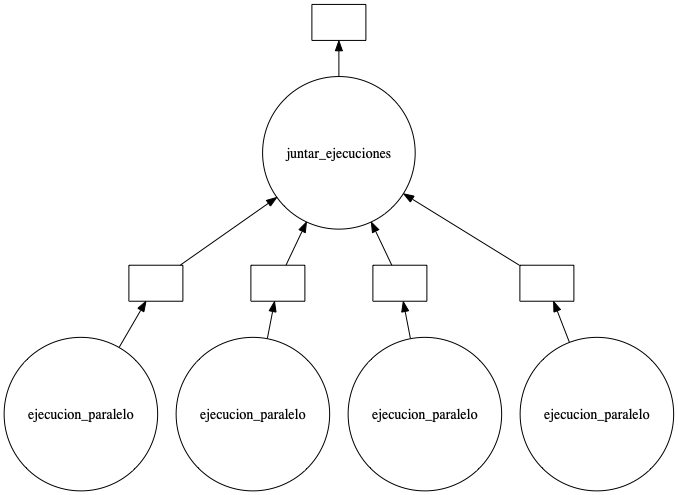

In [21]:
objControl.grafo_Ejecucion.visualize()

(En este caso se tienen 4 cores, por lo que se espera que el tiempo total de ejecución sea aproximadamente una cuarta parte del tiempo en secuencial).

Una vez que se cuenta con el grafo de ejecuión, mediante el método compute() solicitamos que se ejecute como tal el cálculo de las rutas en paralelo:

In [22]:
%%time
objControl.grafo_Ejecucion.compute()

--fza_ventas: --fza_ventas: --fza_ventas:  93997
--fza_ventas:   35673
 8779580060

--fza_ventas:  94919
--fza_ventas:  46388
--fza_ventas: --fza_ventas:  50367 57635

--fza_ventas:  54210
--fza_ventas:  79974
--fza_ventas:  90318
--fza_ventas:  84424
--fza_ventas:  80993
--fza_ventas:  82260
--fza_ventas:  94700
--fza_ventas:  13319
--fza_ventas:  71295
--fza_ventas:  88090
--fza_ventas:  36953
--fza_ventas:  95174
--fza_ventas:  82315
--fza_ventas:  94003
--fza_ventas:  47321
--fza_ventas:  85977
--fza_ventas:  77527
--fza_ventas:  36712
--fza_ventas:  92950
--fza_ventas:  41322
--fza_ventas:  54909
--fza_ventas:  95919
--fza_ventas:  39008
--fza_ventas:  94446
--fza_ventas:  45728
--fza_ventas:  87829
--fza_ventas:  91149
--fza_ventas:  54832
--fza_ventas:  87892
--fza_ventas:  92234
--fza_ventas:  94690
--fza_ventas:  88219
--fza_ventas:  32987
--fza_ventas:  84175
--fza_ventas:  40507
--fza_ventas:  47421
--fza_ventas:  31324
--fza_ventas:  96032
--fza_ventas:  79749
--fza_ventas:

--fza_ventas:  20098
--fza_ventas:  87884
--fza_ventas:  86446
--fza_ventas:  54883
--fza_ventas:  87587
--fza_ventas:  78725
--fza_ventas:  89965
--fza_ventas:  48802
--fza_ventas:  22876
--fza_ventas:  91194
--fza_ventas:  40963
--fza_ventas:  34974
--fza_ventas:  95861
--fza_ventas:  1143
--fza_ventas:  47430
--fza_ventas:  43574
--fza_ventas:  56573
--fza_ventas:  89016
--fza_ventas: --fza_ventas:   4742040162

--fza_ventas:  52689
--fza_ventas:  29375
--fza_ventas:  93686
--fza_ventas:  81663
--fza_ventas:  1342
--fza_ventas:  82522
--fza_ventas:  37525
--fza_ventas:  93832
--fza_ventas:  55261
--fza_ventas:  46852
--fza_ventas: --fza_ventas:  50987 57522

--fza_ventas: --fza_ventas:  74266
 78579
--fza_ventas:  92554
--fza_ventas:  73161
--fza_ventas:  50224
--fza_ventas:  78577
--fza_ventas:  88518
--fza_ventas:  92425
--fza_ventas:  95947
--fza_ventas:  48034
--fza_ventas:  57276
--fza_ventas:  57047
--fza_ventas:  92333
--fza_ventas:  81495
--fza_ventas:  71580
--fza_ventas:  

--fza_ventas:  72508
--fza_ventas:  15230
--fza_ventas:  94963
--fza_ventas:  93266
--fza_ventas:  94958
--fza_ventas:  40590
--fza_ventas:  35328
--fza_ventas:  52693
--fza_ventas:  89968
--fza_ventas:  91964
--fza_ventas:  82337
--fza_ventas:  89621
--fza_ventas:  40617
--fza_ventas:  91073
--fza_ventas:  46693
--fza_ventas:  78221
--fza_ventas:  84820
--fza_ventas:  85792
--fza_ventas:  74530
--fza_ventas:  16930
--fza_ventas:  95281
--fza_ventas:  55219
--fza_ventas:  91197
--fza_ventas:  75344
--fza_ventas:  52874
--fza_ventas:  94846
--fza_ventas:  72115
--fza_ventas:  93198
--fza_ventas:  86181
--fza_ventas:  27611
--fza_ventas:  72058
--fza_ventas:  94405
--fza_ventas:  80561
--fza_ventas:  88440
--fza_ventas:  46581
--fza_ventas:  39723
--fza_ventas:  92864
--fza_ventas:  44303
--fza_ventas:  44669
--fza_ventas:  76633
--fza_ventas:  79569
--fza_ventas:  84945
--fza_ventas:  10146
--fza_ventas:  89065
--fza_ventas:  52611
--fza_ventas:  92446
--fza_ventas:  17490
--fza_ventas:

([0, 0, 0, 0],)

Como se puede apreciar, el tiempo total fue de:

-Aprox 6 segundos para la ejecución DEMO

-Casi 10 minutos para la ejecución REAL

Lo que coincide con la expectativa que se tenía al haber distribuido las fuerzas de venta de acuerdo al número de cores.

## Simulated Annealing

Esta implementación de Simulated Annealing no es posible correrla de manera paralela puesto que internamente hay código que está hecho para correr únicamente sobre el main thread, por lo que al tratar de realizar la corrida en paralelo se presenta un error.

Por lo anterior se procede a ejecutar el algoritmo de manera secuencial:

In [19]:
%%time
objControl.CalcularRutasSeq(sa.SimulatedAnnealing, objControl.dict_Hiper_SA)

--fza_ventas:  35673


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        101.02    24.00%     8.00%     0:00:01     0:00:00

--fza_ventas:  80060


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         24.33    80.00%    42.00%     0:00:01     0:00:00

--fza_ventas:  87795


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         72.73    52.00%    26.00%     0:00:01     0:00:00

--fza_ventas:  93997


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         56.62    46.00%    18.00%     0:00:01     0:00:00

--fza_ventas:  94919


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         36.88    44.00%    10.00%     0:00:01     0:00:00

--fza_ventas:  57635


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         27.18    70.00%    30.00%     0:00:01     0:00:00

--fza_ventas:  50367


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        133.91    24.00%    12.00%     0:00:01     0:00:00

--fza_ventas:  46388


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         31.56    60.00%    36.00%     0:00:01     0:00:00

--fza_ventas:  54210


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         69.34    16.00%     8.00%     0:00:01     0:00:00

--fza_ventas:  84424


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         31.91    50.00%    28.00%     0:00:01     0:00:00

--fza_ventas:  79974


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         37.70    76.00%    36.00%     0:00:01     0:00:00

--fza_ventas:  90318


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         25.09    62.00%    28.00%     0:00:01     0:00:00

--fza_ventas:  80993


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000          5.77    68.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  94700


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         26.95    72.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  13319


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         18.09    74.00%    34.00%     0:00:00     0:00:00

--fza_ventas:  82260


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         53.22    52.00%    24.00%     0:00:01     0:00:00

--fza_ventas:  71295


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         28.07    44.00%    16.00%     0:00:01     0:00:00

--fza_ventas:  88090


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         57.86    32.00%    10.00%     0:00:01     0:00:00

--fza_ventas:  95174


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         52.07    20.00%    10.00%     0:00:01     0:00:00

--fza_ventas:  36953


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         42.64    68.00%    44.00%     0:00:01     0:00:00

--fza_ventas:  82315


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         23.25    68.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  94003


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000       2904.59    12.00%     6.00%     0:00:00     0:00:00

--fza_ventas:  85977


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         83.97    50.00%    24.00%     0:00:01     0:00:00

--fza_ventas:  47321


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         79.83    24.00%    10.00%     0:00:01     0:00:00

--fza_ventas:  77527


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         22.49    50.00%    24.00%     0:00:00     0:00:00

--fza_ventas:  92950


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         10.36    80.00%    48.00%     0:00:00     0:00:00

--fza_ventas:  41322


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         27.71    32.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  36712


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        155.95    30.00%    18.00%     0:00:00     0:00:00

--fza_ventas:  54909


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         63.43    70.00%    32.00%     0:00:01     0:00:00

--fza_ventas:  39008


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         46.64    84.00%    34.00%     0:00:01     0:00:00

--fza_ventas:  94446


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        145.50    32.00%    14.00%     0:00:00     0:00:00

--fza_ventas:  95919


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         35.00    84.00%    42.00%     0:00:01     0:00:00

--fza_ventas:  45728


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         93.80    32.00%    18.00%     0:00:00     0:00:00

--fza_ventas:  91149


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        135.94    56.00%    30.00%     0:00:00     0:00:00

--fza_ventas:  54832


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         56.94    26.00%    12.00%     0:00:01     0:00:00

--fza_ventas:  87829


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         59.84    48.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  87892


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        100.40    42.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  88219


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         76.06    46.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  94690


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         32.47    62.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  92234


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        968.11    58.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  32987


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         29.10    68.00%    36.00%     0:00:01     0:00:00

--fza_ventas:  47421


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        171.98    62.00%    20.00%     0:00:01     0:00:00

--fza_ventas:  40507


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         33.15    66.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  84175


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         40.20    70.00%    38.00%     0:00:00     0:00:00

--fza_ventas:  31324


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         44.79    40.00%    14.00%     0:00:00     0:00:00

--fza_ventas:  92134


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         38.79    50.00%    34.00%     0:00:00     0:00:00

--fza_ventas:  79749


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         36.47    68.00%    36.00%     0:00:00     0:00:00

--fza_ventas:  96032


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         17.85    64.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  95214


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         16.16    80.00%    40.00%     0:00:00     0:00:00

--fza_ventas:  93007


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         32.21    52.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  5623


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        101.64    58.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  79339


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         18.29    64.00%    36.00%     0:00:00     0:00:00

--fza_ventas:  57810


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         33.29    36.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  27776


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         26.33    82.00%    44.00%     0:00:00     0:00:00

--fza_ventas:  88096


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         25.10    58.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  96292


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         20.86    60.00%    34.00%     0:00:00     0:00:00

--fza_ventas:  85073


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         20.01    78.00%    38.00%     0:00:00     0:00:00

--fza_ventas:  84072


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         34.43    30.00%    14.00%     0:00:01     0:00:00

--fza_ventas:  79109


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         22.41    64.00%    36.00%     0:00:00     0:00:00

--fza_ventas:  92088


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         31.27    14.00%     4.00%     0:00:00     0:00:00

--fza_ventas:  92561


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         11.75    72.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  86285


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         41.70    36.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  22072


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         41.85    60.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  30797


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         31.15    68.00%    28.00%     0:00:01     0:00:00

--fza_ventas:  95901


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         12.87    68.00%    34.00%     0:00:01     0:00:00

--fza_ventas:  38595


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         49.81    22.00%     8.00%     0:00:01     0:00:00

--fza_ventas:  86201


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         87.99    68.00%    36.00%     0:00:00     0:00:00

--fza_ventas:  28045


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         25.91    54.00%    24.00%     0:00:01     0:00:00

--fza_ventas:  95906


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        127.51    50.00%    12.00%     0:00:00     0:00:00

--fza_ventas:  16224


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        193.39    34.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  77088


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         21.17    40.00%    16.00%     0:00:01     0:00:00

--fza_ventas:  83056


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         38.05    46.00%    14.00%     0:00:01     0:00:00

--fza_ventas:  41509


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         64.02    30.00%    16.00%     0:00:01     0:00:00

--fza_ventas:  78938


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         77.24    14.00%     4.00%     0:00:00     0:00:00

--fza_ventas:  77195


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         37.27    76.00%    38.00%     0:00:01     0:00:00

--fza_ventas:  34673


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         57.00    62.00%    30.00%     0:00:00     0:00:00

--fza_ventas:  79308


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         29.07    46.00%    18.00%     0:00:00     0:00:00

--fza_ventas:  87295


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         23.04    70.00%    36.00%     0:00:00     0:00:00

--fza_ventas:  93651


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         78.08    46.00%    18.00%     0:00:00     0:00:00

--fza_ventas:  55020


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         36.61    54.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  72983


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        287.61    26.00%    12.00%     0:00:00     0:00:00

--fza_ventas:  46669


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         55.68    38.00%    16.00%     0:00:01     0:00:00

--fza_ventas:  40111


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         55.16    26.00%     8.00%     0:00:01     0:00:00

--fza_ventas:  90709


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         43.20    82.00%    38.00%     0:00:01     0:00:00

--fza_ventas:  90147


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         28.02    84.00%    48.00%     0:00:00     0:00:00

--fza_ventas:  84998


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         50.46    68.00%    38.00%     0:00:00     0:00:00

--fza_ventas:  33369


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         15.00    86.00%    48.00%     0:00:00     0:00:00

--fza_ventas:  58137


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         24.31    66.00%    34.00%     0:00:00     0:00:00

--fza_ventas:  89571


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         11.26    54.00%    24.00%     0:00:00     0:00:00

--fza_ventas:  95826


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         22.17    78.00%    44.00%     0:00:00     0:00:00

--fza_ventas:  84302


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         44.55    46.00%    18.00%     0:00:00     0:00:00

--fza_ventas:  74603


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         25.87    58.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  84650


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         30.69    62.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  91010


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         20.68    62.00%    38.00%     0:00:00     0:00:00

--fza_ventas:  95244


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         27.59    46.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  43753


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        215.01    22.00%    12.00%     0:00:00     0:00:00

--fza_ventas:  81433


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         35.30    62.00%    22.00%     0:00:01     0:00:00

--fza_ventas:  85696


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        105.36    12.00%     6.00%     0:00:00     0:00:00

--fza_ventas:  86402


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         44.31    32.00%    10.00%     0:00:00     0:00:00

--fza_ventas:  79190


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         24.97    74.00%    14.00%     0:00:00     0:00:00

--fza_ventas:  92544


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         31.25    58.00%    30.00%     0:00:00     0:00:00

--fza_ventas:  22103


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         86.47    22.00%    12.00%     0:00:00     0:00:00

--fza_ventas:  45123


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         46.95    42.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  83154


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         35.36    24.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  55260


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         51.85    40.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  77541


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         43.68    48.00%    24.00%     0:00:00     0:00:00

--fza_ventas:  93346


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         62.28    26.00%    14.00%     0:00:01     0:00:00

--fza_ventas:  43597


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         43.36    22.00%    12.00%     0:00:00     0:00:00

--fza_ventas:  84020


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000      18144.32    48.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  17112


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         52.30    62.00%    28.00%     0:00:01     0:00:00

--fza_ventas:  52935


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        227.32    26.00%    12.00%     0:00:00     0:00:00

--fza_ventas:  93245


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         63.51    22.00%    12.00%     0:00:00     0:00:00

--fza_ventas:  44509


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         37.30    54.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  25029


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         63.47    34.00%    14.00%     0:00:01     0:00:00

--fza_ventas:  85794


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         40.93    34.00%    14.00%     0:00:00     0:00:00

--fza_ventas:  74056


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         25.02    70.00%    34.00%     0:00:00     0:00:00

--fza_ventas:  40232


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         26.86    72.00%    48.00%     0:00:00     0:00:00

--fza_ventas:  95245


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         75.81    38.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  92957


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        169.72    56.00%    24.00%     0:00:00     0:00:00

--fza_ventas:  90144


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         45.17    38.00%    24.00%     0:00:00     0:00:00

--fza_ventas:  55554


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        138.20    64.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  58123


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         52.16    22.00%    10.00%     0:00:00     0:00:00

--fza_ventas:  15782


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         36.12    30.00%    14.00%     0:00:00     0:00:00

--fza_ventas:  54979


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000       1827.38    22.00%    12.00%     0:00:00     0:00:00

--fza_ventas:  86270


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         49.61    30.00%    12.00%     0:00:00     0:00:00

--fza_ventas:  88975


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         30.57    68.00%    30.00%     0:00:00     0:00:00

--fza_ventas:  94894


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         27.26    56.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  91171
--fza_ventas:  85534


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         23.94    50.00%    24.00%     0:00:00     0:00:00

--fza_ventas:  86280


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         32.38    72.00%    38.00%     0:00:00     0:00:00

--fza_ventas:  91993


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         35.88    68.00%    36.00%     0:00:01     0:00:00

--fza_ventas:  88526


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         86.39    18.00%     8.00%     0:00:00     0:00:00

--fza_ventas:  56352


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         89.91    22.00%     2.00%     0:00:00     0:00:00

--fza_ventas:  84445


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         47.47    54.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  88088


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         42.18    58.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  92101


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         18.18    80.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  89103


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        157.43    72.00%    24.00%     0:00:01     0:00:00

--fza_ventas:  90292


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         33.75    88.00%    44.00%     0:00:00     0:00:00

--fza_ventas:  93868


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         39.21    38.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  93263


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         67.89    50.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  91719


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         31.56    54.00%    30.00%     0:00:01     0:00:00

--fza_ventas:  49440


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         25.46    62.00%    38.00%     0:00:01     0:00:00

--fza_ventas:  81388


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         43.13    54.00%    26.00%     0:00:01     0:00:00

--fza_ventas:  44245


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         45.43    42.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  10722


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         37.08    26.00%    12.00%     0:00:00     0:00:00

--fza_ventas:  91920


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         49.60    64.00%    34.00%     0:00:01     0:00:00

--fza_ventas:  78298


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         27.34    30.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  42052


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         34.52    54.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  86571


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         44.45    68.00%    32.00%     0:00:01     0:00:00

--fza_ventas:  81889


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         21.58    72.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  88965


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         66.70    44.00%    20.00%     0:00:01     0:00:00

--fza_ventas:  89376


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         36.13    20.00%    10.00%     0:00:00     0:00:00

--fza_ventas:  8430


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         93.54    34.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  57342


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         69.07    40.00%    14.00%     0:00:00     0:00:00

--fza_ventas:  73704


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         50.07    36.00%    10.00%     0:00:01     0:00:00

--fza_ventas:  80361


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         63.33    44.00%    20.00%     0:00:01     0:00:00

--fza_ventas:  90614


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         36.30    22.00%    14.00%     0:00:00     0:00:00

--fza_ventas:  92562


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        489.27    64.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  47377


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         32.67    48.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  36928


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         24.92    54.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  71960


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         29.26    70.00%    30.00%     0:00:00     0:00:00

--fza_ventas:  92487


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         21.25    52.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  71798


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         13.78    76.00%    38.00%     0:00:00     0:00:00

--fza_ventas:  78080


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         21.44    80.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  91814


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        165.51    44.00%    10.00%     0:00:00     0:00:00

--fza_ventas:  94765


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         31.59    44.00%    22.00%     0:00:01     0:00:00

--fza_ventas:  37831


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        127.74    40.00%    18.00%     0:00:00     0:00:00

--fza_ventas:  95678


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         24.88    40.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  91694


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        128.99    60.00%    36.00%     0:00:00     0:00:00

--fza_ventas:  81393


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         35.51    88.00%    44.00%     0:00:00     0:00:00

--fza_ventas:  89009


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         51.79    34.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  93906


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         30.21    58.00%    30.00%     0:00:00     0:00:00

--fza_ventas:  78237


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         31.21    70.00%    36.00%     0:00:00     0:00:00

--fza_ventas:  95954


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         10.39    48.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  89806


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         19.27    68.00%    38.00%     0:00:00     0:00:00

--fza_ventas:  83978


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         28.13    56.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  43886


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         21.83    74.00%    36.00%     0:00:00     0:00:00

--fza_ventas:  94035


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         78.35    30.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  88280


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         48.81    66.00%    34.00%     0:00:00     0:00:00

--fza_ventas:  86281


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         68.98    48.00%    18.00%     0:00:01     0:00:00

--fza_ventas:  49644


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         75.37    38.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  94573


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         33.75    48.00%    18.00%     0:00:01     0:00:00

--fza_ventas:  95942


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000          4.54    74.00%    36.00%     0:00:00     0:00:00

--fza_ventas:  22645


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         32.07    80.00%    46.00%     0:00:00     0:00:00

--fza_ventas:  77949


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         77.99    70.00%    34.00%     0:00:01     0:00:00

--fza_ventas:  84956


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         25.46    82.00%    38.00%     0:00:00     0:00:00

--fza_ventas:  73202


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         13.67    82.00%    42.00%     0:00:00     0:00:00

--fza_ventas:  71114


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         27.09    64.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  91648


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         28.64    62.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  92960


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         11.83    88.00%    46.00%     0:00:00     0:00:00

--fza_ventas:  92178


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         68.00    64.00%    38.00%     0:00:00     0:00:00

--fza_ventas:  46764


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        134.30    22.00%     6.00%     0:00:00     0:00:00

--fza_ventas:  25688


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         33.19    36.00%    10.00%     0:00:00     0:00:00

--fza_ventas:  35238


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         31.78    48.00%    24.00%     0:00:00     0:00:00

--fza_ventas:  93314


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         30.64    50.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  87487


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         20.09    72.00%    42.00%     0:00:00     0:00:00

--fza_ventas:  78218


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         27.04    84.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  87827


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         50.36    66.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  77634


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         40.01    70.00%    36.00%     0:00:01     0:00:00

--fza_ventas:  54182


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         47.93    60.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  83910


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         22.47    66.00%    34.00%     0:00:01     0:00:00

--fza_ventas:  91854


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        140.18    30.00%    12.00%     0:00:01     0:00:00

--fza_ventas:  94015


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         17.65    54.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  84443


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         33.48    54.00%    22.00%     0:00:01     0:00:00

--fza_ventas:  87886


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        161.12    40.00%    18.00%     0:00:01     0:00:00

--fza_ventas:  94992


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        112.50    48.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  91580


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         29.69    68.00%    42.00%     0:00:00     0:00:00

--fza_ventas:  84600


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         27.00    68.00%    32.00%     0:00:01     0:00:00

--fza_ventas:  83987


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         34.06    76.00%    34.00%     0:00:01     0:00:00

--fza_ventas:  51620


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         42.64    62.00%    28.00%     0:00:01     0:00:00

--fza_ventas:  85479


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         45.79    50.00%    20.00%     0:00:01     0:00:00

--fza_ventas:  81253


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         55.17    44.00%    20.00%     0:00:01     0:00:00

--fza_ventas:  28088


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        685.73    16.00%     8.00%     0:00:01     0:00:00

--fza_ventas:  83523


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         19.32    72.00%    36.00%     0:00:01     0:00:00

--fza_ventas:  73430


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         43.69    44.00%    22.00%     0:00:01     0:00:00

--fza_ventas:  55608


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         14.83    82.00%    38.00%     0:00:01     0:00:00

--fza_ventas:  92650


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         25.94    40.00%    12.00%     0:00:01     0:00:00

--fza_ventas:  78941


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         42.01    36.00%    16.00%     0:00:01     0:00:00

--fza_ventas:  77655


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         24.39    52.00%    32.00%     0:00:01     0:00:00

--fza_ventas:  83344


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         39.52    56.00%    34.00%     0:00:01     0:00:00

--fza_ventas:  91049


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         36.90    32.00%    14.00%     0:00:01     0:00:00

--fza_ventas:  50872


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000       1541.45    32.00%    14.00%     0:00:01     0:00:00

--fza_ventas:  58348


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         21.99    86.00%    48.00%     0:00:01     0:00:00

--fza_ventas:  74268


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         53.78    68.00%    36.00%     0:00:01     0:00:00

--fza_ventas:  56448


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         20.46    74.00%    40.00%     0:00:01     0:00:00

--fza_ventas:  86560


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         18.71    72.00%    30.00%     0:00:01     0:00:00

--fza_ventas:  85941


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        112.01    46.00%    22.00%     0:00:01     0:00:00

--fza_ventas:  73004


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         38.04    56.00%    26.00%     0:00:01     0:00:00

--fza_ventas:  82083


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         23.11    60.00%    26.00%     0:00:01     0:00:00

--fza_ventas:  95897


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         36.01    66.00%    36.00%     0:00:01     0:00:00

--fza_ventas:  85134


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         33.70    74.00%    38.00%     0:00:00     0:00:00

--fza_ventas:  82528


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         63.57    46.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  87208


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         55.91    34.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  94036


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         20.62    66.00%    36.00%     0:00:00     0:00:00

--fza_ventas:  79121


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         42.64    28.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  89798


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        203.43    38.00%    22.00%     0:00:01     0:00:00

--fza_ventas:  95231


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         88.87    20.00%     2.00%     0:00:00     0:00:00

--fza_ventas:  36826


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         45.96    36.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  94565


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         26.25    58.00%    30.00%     0:00:00     0:00:00

--fza_ventas:  90459


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        205.48    34.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  91948


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         58.77    34.00%    22.00%     0:00:01     0:00:00

--fza_ventas:  90710


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         28.11    66.00%    42.00%     0:00:00     0:00:00

--fza_ventas:  72853


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000       3627.71    42.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  82033


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         46.27    54.00%    20.00%     0:00:01     0:00:00

--fza_ventas:  75938


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         39.72    66.00%    28.00%     0:00:01     0:00:00

--fza_ventas:  76079


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        402.68    28.00%     6.00%     0:00:01     0:00:00

--fza_ventas:  88934


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        127.11    50.00%    24.00%     0:00:00     0:00:00

--fza_ventas:  94628


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         27.28    58.00%    30.00%     0:00:00     0:00:00

--fza_ventas:  22729


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         50.69    38.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  83153


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         52.03    36.00%    14.00%     0:00:00     0:00:00

--fza_ventas:  75889


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         84.94    56.00%    34.00%     0:00:01     0:00:00

--fza_ventas:  95165


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         29.60    36.00%    12.00%     0:00:00     0:00:00

--fza_ventas:  75909


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         39.39    76.00%    38.00%     0:00:01     0:00:00

--fza_ventas:  75427


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         50.21    58.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  85908


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        100.63    40.00%    10.00%     0:00:00     0:00:00

--fza_ventas:  10913


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         38.14    30.00%    12.00%     0:00:00     0:00:00

--fza_ventas:  94397


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         19.92    76.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  39963


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         57.87    36.00%    14.00%     0:00:00     0:00:00

--fza_ventas:  96239


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000          8.82    90.00%    40.00%     0:00:00     0:00:00

--fza_ventas:  89570


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         47.89    30.00%     4.00%     0:00:00     0:00:00

--fza_ventas:  91937


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         24.43    62.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  79921


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         30.46    74.00%    30.00%     0:00:00     0:00:00

--fza_ventas:  84847


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         71.10    16.00%     4.00%     0:00:01     0:00:00

--fza_ventas:  84987


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         32.84    48.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  86200


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         28.77    54.00%    28.00%     0:00:01     0:00:00

--fza_ventas:  49066


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         79.98    36.00%    18.00%     0:00:01     0:00:00

--fza_ventas:  57358


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         20.19    94.00%    36.00%     0:00:01     0:00:00

--fza_ventas:  10119


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         42.00    24.00%    10.00%     0:00:01     0:00:00

--fza_ventas:  75023


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         35.49    62.00%    30.00%     0:00:01     0:00:00

--fza_ventas:  37291


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         31.74    36.00%    18.00%     0:00:01     0:00:00

--fza_ventas:  73747


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        156.45    36.00%    18.00%     0:00:01     0:00:00

--fza_ventas:  85153


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         52.53    28.00%    14.00%     0:00:01     0:00:00

--fza_ventas:  84088


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         57.91    52.00%    38.00%     0:00:00     0:00:00

--fza_ventas:  95681


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         14.81    48.00%    12.00%     0:00:00     0:00:00

--fza_ventas:  47704


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         36.59    46.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  91688


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         18.14    64.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  45572


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         37.28    42.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  53054


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         81.09    16.00%    12.00%     0:00:01     0:00:00

--fza_ventas:  95180


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         39.51    30.00%    14.00%     0:00:01     0:00:00

--fza_ventas:  92151


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         34.62    68.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  94205


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         20.49    66.00%    34.00%     0:00:00     0:00:00

--fza_ventas:  41768


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         97.63    18.00%    10.00%     0:00:01     0:00:00

--fza_ventas:  81484


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         47.56    54.00%    30.00%     0:00:00     0:00:00

--fza_ventas:  92683


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         69.90    16.00%     2.00%     0:00:00     0:00:00

--fza_ventas:  50239


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         43.38    54.00%    32.00%     0:00:01     0:00:00

--fza_ventas:  90316


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         28.39    62.00%    26.00%     0:00:01     0:00:00

--fza_ventas:  51748


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000       1538.72    44.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  73753


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         33.74    60.00%    24.00%     0:00:01     0:00:00

--fza_ventas:  78856


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        113.68    12.00%     6.00%     0:00:00     0:00:00

--fza_ventas:  94586


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         33.56    26.00%    14.00%     0:00:00     0:00:00

--fza_ventas:  72110


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         39.02    72.00%    32.00%     0:00:01     0:00:00

--fza_ventas:  87756


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         16.63    78.00%    40.00%     0:00:00     0:00:00

--fza_ventas:  82420


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         15.08    56.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  37558


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000       1037.82    30.00%    10.00%     0:00:00     0:00:00

--fza_ventas:  6922


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        408.85    14.00%     6.00%     0:00:01     0:00:00

--fza_ventas:  71644


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         31.27    44.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  85127


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         45.75    44.00%    22.00%     0:00:01     0:00:00

--fza_ventas:  51303


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         39.10    50.00%    18.00%     0:00:01     0:00:00

--fza_ventas:  31880


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        160.32    26.00%     8.00%     0:00:01     0:00:00

--fza_ventas:  94407


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        152.79    16.00%     8.00%     0:00:00     0:00:00

--fza_ventas:  79740


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         31.09    48.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  79837


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         95.38    28.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  85420


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         59.62    52.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  88296


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         29.84    64.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  87808


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         40.61    40.00%    16.00%     0:00:01     0:00:00

--fza_ventas:  56303


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         25.99    90.00%    48.00%     0:00:00     0:00:00

--fza_ventas:  85564


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         32.75    54.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  83950


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         38.48    38.00%    20.00%     0:00:01     0:00:00

--fza_ventas:  82721


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         43.13    42.00%    22.00%     0:00:01     0:00:00

--fza_ventas:  58347


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         62.19    62.00%    32.00%     0:00:01     0:00:00

--fza_ventas:  95977


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         38.10    50.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  82320


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         53.43    42.00%    24.00%     0:00:00     0:00:00

--fza_ventas:  84172


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         18.65    60.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  95205


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         89.09    36.00%    18.00%     0:00:00     0:00:00

--fza_ventas:  92619


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         29.00    58.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  95973


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        116.23    26.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  88251


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         21.46    68.00%    38.00%     0:00:00     0:00:00

--fza_ventas:  51700


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         19.97    88.00%    40.00%     0:00:00     0:00:00

--fza_ventas:  42177


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         48.34    38.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  92277


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         12.15    76.00%    42.00%     0:00:00     0:00:00

--fza_ventas:  10102


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        605.37     6.00%     2.00%     0:00:01     0:00:00

--fza_ventas:  80953


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         65.76    24.00%     8.00%     0:00:00     0:00:00

--fza_ventas:  90644


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         21.73    54.00%    40.00%     0:00:01     0:00:00

--fza_ventas:  95547


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000          7.51    76.00%    24.00%     0:00:00     0:00:00

--fza_ventas:  83123


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         42.88    66.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  86883


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         31.76    56.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  40714


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         27.98    38.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  41895


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         53.50    40.00%    22.00%     0:00:01     0:00:00

--fza_ventas:  86862


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         35.06    50.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  82832


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        135.11    50.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  76011


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         17.81    50.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  76604


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         15.76    62.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  90300


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         16.08    80.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  93078


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         30.79    48.00%    30.00%     0:00:01     0:00:00

--fza_ventas:  85712


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        158.69    16.00%     8.00%     0:00:01     0:00:00

--fza_ventas:  50915


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         45.40    64.00%    34.00%     0:00:00     0:00:00

--fza_ventas:  28937


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         42.06    70.00%    30.00%     0:00:00     0:00:00

--fza_ventas:  95257


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        166.32    22.00%     8.00%     0:00:00     0:00:00

--fza_ventas:  91960


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        227.01    10.00%     0.00%     0:00:00     0:00:00

--fza_ventas:  93192


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         23.69    84.00%    44.00%     0:00:01     0:00:00

--fza_ventas:  87960


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         22.93    58.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  58228


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         21.80    70.00%    30.00%     0:00:00     0:00:00

--fza_ventas:  74270


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         35.78    74.00%    36.00%     0:00:00     0:00:00

--fza_ventas:  72456


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         43.31    50.00%    22.00%     0:00:01     0:00:00

--fza_ventas:  28041


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         33.05    70.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  85894


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         28.96    70.00%    36.00%     0:00:01     0:00:00

--fza_ventas:  36368


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         84.63    26.00%    10.00%     0:00:00     0:00:00

--fza_ventas:  93724


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         29.12    58.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  71080


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         19.12    66.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  85138


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         22.32    68.00%    26.00%     0:00:01     0:00:00

--fza_ventas:  87609


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         30.42    68.00%    40.00%     0:00:00     0:00:00

--fza_ventas:  79853


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         50.19    58.00%    26.00%     0:00:01     0:00:00

--fza_ventas:  94561


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         18.38    86.00%    40.00%     0:00:00     0:00:00

--fza_ventas:  56150


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         23.72    26.00%    12.00%     0:00:00     0:00:00

--fza_ventas:  85214


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         38.98    72.00%    42.00%     0:00:01     0:00:00

--fza_ventas:  88439


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         55.04    38.00%    18.00%     0:00:00     0:00:00

--fza_ventas:  89837


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         95.67    44.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  94708


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         29.37    80.00%    26.00%     0:00:01     0:00:00

--fza_ventas:  37938


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         29.95    50.00%    18.00%     0:00:00     0:00:00

--fza_ventas:  81703


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         37.79    54.00%    22.00%     0:00:01     0:00:00

--fza_ventas:  85490


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         86.34    30.00%    16.00%     0:00:01     0:00:00

--fza_ventas:  92124


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         20.74    66.00%    34.00%     0:00:01     0:00:00

--fza_ventas:  88517


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         29.43    70.00%    30.00%     0:00:00     0:00:00

--fza_ventas:  80912


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         22.26    68.00%    30.00%     0:00:00     0:00:00

--fza_ventas:  84069


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         34.80    66.00%    40.00%     0:00:00     0:00:00

--fza_ventas:  71253


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         92.90    16.00%     6.00%     0:00:00     0:00:00

--fza_ventas:  40872


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         34.46    82.00%    40.00%     0:00:01     0:00:00

--fza_ventas:  50805


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        122.11    36.00%    18.00%     0:00:00     0:00:00

--fza_ventas:  37229


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         23.69    70.00%    38.00%     0:00:00     0:00:00

--fza_ventas:  93884


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         50.93    56.00%    20.00%     0:00:01     0:00:00

--fza_ventas:  92099


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         20.24    56.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  94004


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         23.43    40.00%    14.00%     0:00:00     0:00:00

--fza_ventas:  89069


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         39.10    30.00%    12.00%     0:00:01     0:00:00

--fza_ventas:  51575


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000          4.83    86.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  57293


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         30.53    72.00%    40.00%     0:00:00     0:00:00

--fza_ventas:  85203


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         33.47    48.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  91013


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         30.39    62.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  14967


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         63.06    44.00%    12.00%     0:00:00     0:00:00

--fza_ventas:  96245


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         37.17    40.00%    18.00%     0:00:00     0:00:00

--fza_ventas:  95859


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         26.87    80.00%    34.00%     0:00:01     0:00:00

--fza_ventas:  52819


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         67.58    26.00%    12.00%     0:00:00     0:00:00

--fza_ventas:  52226


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        119.91    78.00%    34.00%     0:00:00     0:00:00

--fza_ventas:  85857


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        111.72    26.00%     6.00%     0:00:00     0:00:00

--fza_ventas:  80061


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         43.60    68.00%    36.00%     0:00:01     0:00:00

--fza_ventas:  85485


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         55.48    30.00%    10.00%     0:00:00     0:00:00

--fza_ventas:  27118


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         23.05    78.00%    36.00%     0:00:00     0:00:00

--fza_ventas:  55427


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         60.40    32.00%    20.00%     0:00:01     0:00:00

--fza_ventas:  54883


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         26.18    50.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  3216


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         37.28    24.00%    12.00%     0:00:01     0:00:00

--fza_ventas:  82148


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        109.80    66.00%    30.00%     0:00:01     0:00:00

--fza_ventas:  94002


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         24.22    54.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  48802


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         50.36    60.00%    34.00%     0:00:01     0:00:00

--fza_ventas:  87884


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         22.54    84.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  20098


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        303.44    18.00%     2.00%     0:00:01     0:00:00

--fza_ventas:  75103


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         26.64    28.00%    12.00%     0:00:00     0:00:00

--fza_ventas:  34974


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        102.20    46.00%    24.00%     0:00:00     0:00:00

--fza_ventas:  78725


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         39.00    60.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  87587


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         27.25    82.00%    38.00%     0:00:01     0:00:00

--fza_ventas:  86446


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        128.63    40.00%    18.00%     0:00:01     0:00:00

--fza_ventas:  43574


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         38.84    42.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  91194


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         17.82    72.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  22876


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         60.73    46.00%    18.00%     0:00:01     0:00:00

--fza_ventas:  89965


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         67.18    44.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  40162


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        122.10    28.00%    16.00%     0:00:01     0:00:00

--fza_ventas:  1143


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         18.42    74.00%    14.00%     0:00:00     0:00:00

--fza_ventas:  95861


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         33.04    50.00%    24.00%     0:00:00     0:00:00

--fza_ventas:  40963


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        148.37    36.00%    24.00%     0:00:01     0:00:00

--fza_ventas:  93686


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        154.33    42.00%    20.00%     0:00:01     0:00:00

--fza_ventas:  89016


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         45.06    30.00%    16.00%     0:00:01     0:00:00

--fza_ventas:  56573


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         14.33    70.00%    36.00%     0:00:00     0:00:00

--fza_ventas:  47430


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         61.29    42.00%    16.00%     0:00:01     0:00:00

--fza_ventas:  37525


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         26.13    76.00%    40.00%     0:00:00     0:00:00

--fza_ventas:  29375


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         61.16    24.00%    12.00%     0:00:01     0:00:00

--fza_ventas:  52689


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         28.39    62.00%    26.00%     0:00:01     0:00:00

--fza_ventas:  47420


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000       1172.13    40.00%    18.00%     0:00:01     0:00:00

--fza_ventas:  57522


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         50.41    66.00%    30.00%     0:00:01     0:00:00

--fza_ventas:  82522


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        127.18    32.00%     8.00%     0:00:00     0:00:00

--fza_ventas:  1342


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         16.24    74.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  81663


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         19.42    66.00%    26.00%     0:00:01     0:00:00

--fza_ventas:  73161


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         80.75    48.00%    30.00%     0:00:00     0:00:00

--fza_ventas:  55261


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         19.90    58.00%    28.00%     0:00:01     0:00:00

--fza_ventas:  46852


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         42.38    70.00%    38.00%     0:00:01     0:00:00

--fza_ventas:  93832


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         50.95    26.00%     8.00%     0:00:00     0:00:00

--fza_ventas:  92425


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         45.26    52.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  74266


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         35.67    52.00%    28.00%     0:00:01     0:00:00

--fza_ventas:  78579


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         30.71    42.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  50987


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        114.37    14.00%     2.00%     0:00:00     0:00:00

--fza_ventas:  57047


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         59.67    48.00%    20.00%     0:00:01     0:00:00

--fza_ventas:  78577


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         33.35    48.00%    22.00%     0:00:01     0:00:00

--fza_ventas:  50224


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         21.07    58.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  92554


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        277.17    12.00%     6.00%     0:00:01     0:00:00

--fza_ventas:  93256


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         26.01    68.00%    24.00%     0:00:00     0:00:00

--fza_ventas:  48034


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        114.96    56.00%    30.00%     0:00:00     0:00:00

--fza_ventas:  95947


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         14.54    80.00%    38.00%     0:00:01     0:00:00

--fza_ventas:  88518


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         39.63    72.00%    38.00%     0:00:00     0:00:00

--fza_ventas:  91064


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         48.37    38.00%    12.00%     0:00:00     0:00:00

--fza_ventas:  81495


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         29.00    56.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  92333


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         24.29    76.00%    40.00%     0:00:00     0:00:00

--fza_ventas:  57276


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         24.57    72.00%    30.00%     0:00:01     0:00:00

--fza_ventas:  44751


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         50.15    42.00%    32.00%     0:00:01     0:00:00

--fza_ventas:  93846


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        148.96    40.00%    18.00%     0:00:00     0:00:00

--fza_ventas:  78413


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         26.19    54.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  71580


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         28.69    62.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  4848


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         78.82    28.00%    18.00%     0:00:01     0:00:00

--fza_ventas:  95428


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         23.90    46.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  80201


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         29.15    58.00%    24.00%     0:00:01     0:00:00

--fza_ventas:  14102


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         31.30    32.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  86226


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         38.22    58.00%    24.00%     0:00:00     0:00:00

--fza_ventas:  80897


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         28.90    60.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  49887


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         34.71    68.00%    38.00%     0:00:01     0:00:00

--fza_ventas:  93676


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         20.35    66.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  91285


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         24.81    70.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  92608


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         55.70    46.00%    24.00%     0:00:01     0:00:00

--fza_ventas:  72212


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         11.87    70.00%    34.00%     0:00:00     0:00:00

--fza_ventas:  18460


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         18.56    38.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  93312


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         20.43    42.00%    16.00%     0:00:01     0:00:00

--fza_ventas:  49422


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         61.24    60.00%    34.00%     0:00:00     0:00:00

--fza_ventas:  87598


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         29.71    52.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  81537


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         66.51    18.00%    10.00%     0:00:00     0:00:00

--fza_ventas:  36138


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         28.22    56.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  51416


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         32.81    62.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  82902


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         35.40    62.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  20240


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         30.65    38.00%    14.00%     0:00:01     0:00:00

--fza_ventas:  40260


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        106.00    36.00%    18.00%     0:00:01     0:00:00

--fza_ventas:  94969


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         35.59    80.00%    34.00%     0:00:01     0:00:00

--fza_ventas:  77521


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         33.15    62.00%    34.00%     0:00:00     0:00:00

--fza_ventas:  79613


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         37.17    42.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  56015


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         49.32    52.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  89400


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         71.38    30.00%    16.00%     0:00:01     0:00:00

--fza_ventas:  91207


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         75.66    38.00%    22.00%     0:00:01     0:00:00

--fza_ventas:  84241


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         48.47    66.00%    32.00%     0:00:01     0:00:00

--fza_ventas:  89465


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         29.21    80.00%    46.00%     0:00:01     0:00:00

--fza_ventas:  90215


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         15.30    82.00%    38.00%     0:00:01     0:00:00

--fza_ventas:  82122


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         16.71    90.00%    46.00%     0:00:00     0:00:00

--fza_ventas:  81353


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         34.05    48.00%    22.00%     0:00:01     0:00:00

--fza_ventas:  85017


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        205.36    50.00%    18.00%     0:00:01     0:00:00

--fza_ventas:  92095


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         29.61    46.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  79975


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         46.50    52.00%    20.00%     0:00:01     0:00:00

--fza_ventas:  92440


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         36.45    24.00%    10.00%     0:00:01     0:00:00

--fza_ventas:  55066


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         52.24    38.00%    22.00%     0:00:01     0:00:00

--fza_ventas:  28470


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         91.86    14.00%     8.00%     0:00:01     0:00:00

--fza_ventas:  55838


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         49.07    56.00%    32.00%     0:00:01     0:00:00

--fza_ventas:  50256


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         27.57    54.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  45734


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         27.62    62.00%    28.00%     0:00:01     0:00:00

--fza_ventas:  88527


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         21.86    66.00%    34.00%     0:00:00     0:00:00

--fza_ventas:  94725


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         46.74    20.00%    10.00%     0:00:01     0:00:00

--fza_ventas:  54925


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         70.30    20.00%     6.00%     0:00:01     0:00:00

--fza_ventas:  56730


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         42.93    42.00%    14.00%     0:00:01     0:00:00

--fza_ventas:  95969


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         20.02    70.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  18461


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         48.95    32.00%    12.00%     0:00:01     0:00:00

--fza_ventas:  80498


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         28.56    78.00%    40.00%     0:00:01     0:00:00

--fza_ventas:  56654


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         28.46    26.00%     2.00%     0:00:00     0:00:00

--fza_ventas:  87592


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         55.63    56.00%    30.00%     0:00:01     0:00:00

--fza_ventas:  40454


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        162.53    32.00%    16.00%     0:00:01     0:00:00

--fza_ventas:  19685


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         52.27    22.00%    10.00%     0:00:01     0:00:00

--fza_ventas:  94851


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        128.32    30.00%    10.00%     0:00:00     0:00:00

--fza_ventas:  72293


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         37.16    34.00%    12.00%     0:00:00     0:00:00

--fza_ventas:  46579


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         23.65    68.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  78351


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         35.66    50.00%    22.00%     0:00:01     0:00:00

--fza_ventas:  92411


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        116.53    52.00%    24.00%     0:00:00     0:00:00

--fza_ventas:  85672


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         38.41    50.00%    24.00%     0:00:01     0:00:00

--fza_ventas:  74488


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         29.59    30.00%    16.00%     0:00:01     0:00:00

--fza_ventas:  96217


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         91.57    66.00%    28.00%     0:00:01     0:00:00

--fza_ventas:  77016


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         53.60    44.00%    22.00%     0:00:01     0:00:00

--fza_ventas:  57542


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         40.26    28.00%    20.00%     0:00:01     0:00:00

--fza_ventas:  28861


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         23.46    58.00%    36.00%     0:00:01     0:00:00

--fza_ventas:  86574


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         57.52    66.00%    24.00%     0:00:01     0:00:00

--fza_ventas:  17147


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         10.14    80.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  94206


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         25.65    38.00%    16.00%     0:00:01     0:00:00

--fza_ventas:  43133


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         48.19    36.00%    18.00%     0:00:00     0:00:00

--fza_ventas:  87877


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         38.64    64.00%    34.00%     0:00:01     0:00:00

--fza_ventas:  77683


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000       1518.70    78.00%    42.00%     0:00:00     0:00:00

--fza_ventas:  88851


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         41.90    28.00%    14.00%     0:00:01     0:00:00

--fza_ventas:  71629


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         25.66    72.00%    34.00%     0:00:00     0:00:00

--fza_ventas:  88013


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         10.02    74.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  92491


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         20.31    66.00%    32.00%     0:00:01     0:00:00

--fza_ventas:  95296


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         41.48    50.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  86549


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         42.14    64.00%    32.00%     0:00:01     0:00:00

--fza_ventas:  84005


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         51.81    48.00%    12.00%     0:00:01     0:00:00

--fza_ventas:  84883


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000       1534.91    56.00%    26.00%     0:00:01     0:00:00

--fza_ventas:  26460


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         49.43    30.00%    18.00%     0:00:00     0:00:00

--fza_ventas:  84618


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        104.91    18.00%     2.00%     0:00:01     0:00:00

--fza_ventas:  30228


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         25.91    50.00%    28.00%     0:00:01     0:00:00

--fza_ventas:  93310


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         41.54    40.00%    10.00%     0:00:00     0:00:00

--fza_ventas:  71023


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         59.68    40.00%    22.00%     0:00:01     0:00:00

--fza_ventas:  74579


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         33.26    66.00%    30.00%     0:00:01     0:00:00

--fza_ventas:  93087


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         26.91    62.00%    32.00%     0:00:01     0:00:00

--fza_ventas:  29426


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000       1529.61    66.00%    30.00%     0:00:00     0:00:00

--fza_ventas:  75163


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         20.66    70.00%    40.00%     0:00:01     0:00:00

--fza_ventas:  90818


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         46.20    32.00%    14.00%     0:00:00     0:00:00

--fza_ventas:  75406


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         25.45    50.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  83786


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        121.80    38.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  89374


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         52.48    56.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  95258


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        165.00    14.00%    10.00%     0:00:00     0:00:00

--fza_ventas:  82739


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         47.22    40.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  94459


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         12.90    34.00%    14.00%     0:00:00     0:00:00

--fza_ventas:  74334


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         25.51    58.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  91710


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         24.52    80.00%    38.00%     0:00:01     0:00:00

--fza_ventas:  91561


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         54.73    48.00%    22.00%     0:00:01     0:00:00

--fza_ventas:  87470


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         22.40    74.00%    44.00%     0:00:01     0:00:00

--fza_ventas:  93242


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        137.01    52.00%    20.00%     0:00:01     0:00:00

--fza_ventas:  22171


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         51.09    38.00%    12.00%     0:00:00     0:00:00

--fza_ventas:  91714


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        151.80    58.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  56619


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         35.36    66.00%    32.00%     0:00:01     0:00:00

--fza_ventas:  94020


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        163.68    20.00%     8.00%     0:00:00     0:00:00

--fza_ventas:  87147


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         51.47    54.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  92607


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         23.11    48.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  92015


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         72.90    34.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  85555


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        235.12    32.00%    12.00%     0:00:00     0:00:00

--fza_ventas:  82187


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         44.10    42.00%    28.00%     0:00:01     0:00:00

--fza_ventas:  32144


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         12.69    82.00%    38.00%     0:00:00     0:00:00

--fza_ventas:  89267


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         35.85    70.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  38263


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         34.22    70.00%    26.00%     0:00:01     0:00:00

--fza_ventas:  84868


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         41.27    46.00%    26.00%     0:00:01     0:00:00

--fza_ventas:  85774


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         37.58    62.00%    32.00%     0:00:01     0:00:00

--fza_ventas:  95596


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         24.97    62.00%    30.00%     0:00:01     0:00:00

--fza_ventas:  90676


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        107.64    18.00%     2.00%     0:00:01     0:00:00

--fza_ventas:  94692


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         28.87    60.00%    28.00%     0:00:01     0:00:00

--fza_ventas:  35785


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         39.65    60.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  78730


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         22.82    78.00%    38.00%     0:00:00     0:00:00

--fza_ventas:  33981


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         31.23    42.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  71105


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        118.48    28.00%     6.00%     0:00:01     0:00:00

--fza_ventas:  79559


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         20.50    94.00%    42.00%     0:00:00     0:00:00

--fza_ventas:  90432


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         20.36    74.00%    28.00%     0:00:01     0:00:00

--fza_ventas:  34636


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         23.11    30.00%    12.00%     0:00:00     0:00:00

--fza_ventas:  89954


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        112.95    58.00%    20.00%     0:00:01     0:00:00

--fza_ventas:  77665


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         24.75    34.00%    14.00%     0:00:00     0:00:00

--fza_ventas:  89005


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         27.62    68.00%    34.00%     0:00:01     0:00:00

--fza_ventas:  83066


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         76.21    34.00%    16.00%     0:00:01     0:00:00

--fza_ventas:  78888


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         39.07    62.00%    24.00%     0:00:01     0:00:00

--fza_ventas:  85663


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         13.40    94.00%    46.00%     0:00:00     0:00:00

--fza_ventas:  94639


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000       1559.61    26.00%    10.00%     0:00:00     0:00:00

--fza_ventas:  71531


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         27.62    66.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  74775


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        162.37    40.00%    28.00%     0:00:01     0:00:00

--fza_ventas:  41561


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         42.96    36.00%    12.00%     0:00:00     0:00:00

--fza_ventas:  45502


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        132.96    28.00%    16.00%     0:00:01     0:00:00

--fza_ventas:  87449


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         43.03    36.00%    18.00%     0:00:01     0:00:00

--fza_ventas:  94691


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        126.23    14.00%     4.00%     0:00:00     0:00:00

--fza_ventas:  87581


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         45.54    46.00%    26.00%     0:00:01     0:00:00

--fza_ventas:  93840


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         44.26    40.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  50551


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         11.74    60.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  29728


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        460.30    48.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  92213


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         44.36    46.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  80059


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         46.14    56.00%    24.00%     0:00:01     0:00:00

--fza_ventas:  57167


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         47.12    64.00%    32.00%     0:00:01     0:00:00

--fza_ventas:  81108


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         23.03    78.00%    40.00%     0:00:00     0:00:00

--fza_ventas:  94866


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000       1388.34    60.00%    18.00%     0:00:01     0:00:00

--fza_ventas:  123


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         33.64    54.00%    24.00%     0:00:00     0:00:00

--fza_ventas:  83927


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         41.88    54.00%    24.00%     0:00:00     0:00:00

--fza_ventas:  50161


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         21.10    70.00%    28.00%     0:00:01     0:00:00

--fza_ventas:  78409


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         41.21    18.00%     6.00%     0:00:00     0:00:00

--fza_ventas:  93178


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         32.72    78.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  88382


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         51.59    46.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  90800


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         37.10    64.00%    30.00%     0:00:01     0:00:00

--fza_ventas:  41048


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         25.11    68.00%    30.00%     0:00:00     0:00:00

--fza_ventas:  51184


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        122.78    26.00%     4.00%     0:00:00     0:00:00

--fza_ventas:  88141


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         51.08    68.00%    28.00%     0:00:01     0:00:00

--fza_ventas:  90636


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         20.00    56.00%    24.00%     0:00:01     0:00:00

--fza_ventas:  17798


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000       3629.37    62.00%    32.00%     0:00:01     0:00:00

--fza_ventas:  54628


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         81.46    42.00%    24.00%     0:00:01     0:00:00

--fza_ventas:  72191


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         14.08    70.00%    28.00%     0:00:01     0:00:00

--fza_ventas:  74539


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         84.42    58.00%    28.00%     0:00:01     0:00:00

--fza_ventas:  49488


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         26.04    86.00%    54.00%     0:00:01     0:00:00

--fza_ventas:  72201


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         22.42    58.00%    34.00%     0:00:00     0:00:00

--fza_ventas:  53026


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         78.05    30.00%    12.00%     0:00:00     0:00:00

--fza_ventas:  83199


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         27.11    66.00%    30.00%     0:00:00     0:00:00

--fza_ventas:  86525


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         65.21    40.00%    16.00%     0:00:01     0:00:00

--fza_ventas:  58055


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         11.88    90.00%    42.00%     0:00:00     0:00:00

--fza_ventas:  81832


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         21.96    58.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  47432


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         46.21    36.00%    10.00%     0:00:01     0:00:00

--fza_ventas:  55854


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         42.84    82.00%    34.00%     0:00:01     0:00:00

--fza_ventas:  93292


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         45.29    80.00%    46.00%     0:00:00     0:00:00

--fza_ventas:  88093


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        147.80    74.00%    40.00%     0:00:01     0:00:00

--fza_ventas:  92464


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         71.70    54.00%    24.00%     0:00:01     0:00:00

--fza_ventas:  78356


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        180.82    24.00%    14.00%     0:00:00     0:00:00

--fza_ventas:  86191


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         36.24    66.00%    36.00%     0:00:01     0:00:00

--fza_ventas:  8099


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         32.33    52.00%    24.00%     0:00:01     0:00:00

--fza_ventas:  27467


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         34.72    46.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  77721


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         99.02    36.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  81621


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         22.53    54.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  90701


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         77.60    26.00%    10.00%     0:00:01     0:00:00

--fza_ventas:  52216


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         33.50    58.00%    24.00%     0:00:00     0:00:00

--fza_ventas:  71947


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         32.09    74.00%    30.00%     0:00:00     0:00:00

--fza_ventas:  94162


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         29.95    42.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  91195


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         20.43    80.00%    42.00%     0:00:00     0:00:00

--fza_ventas:  85449


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         56.66    34.00%    24.00%     0:00:00     0:00:00

--fza_ventas:  79307


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         40.26    52.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  82917


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         33.23    50.00%    24.00%     0:00:00     0:00:00

--fza_ventas:  86653


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        122.94    16.00%     6.00%     0:00:00     0:00:00

--fza_ventas:  41461


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         76.02    30.00%    12.00%     0:00:01     0:00:00

--fza_ventas:  84797


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        223.48     8.00%     0.00%     0:00:00     0:00:00

--fza_ventas:  94117


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         33.18    42.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  53034


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        141.45    52.00%    24.00%     0:00:01     0:00:00

--fza_ventas:  79930


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         16.34    82.00%    46.00%     0:00:01     0:00:00

--fza_ventas:  87869


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         50.82    56.00%    36.00%     0:00:01     0:00:00

--fza_ventas:  56208


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        166.87    16.00%    10.00%     0:00:00     0:00:00

--fza_ventas:  33832


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         44.58    62.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  95978


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         33.84    48.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  95266


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         20.20    70.00%    38.00%     0:00:00     0:00:00

--fza_ventas:  39993


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         19.59    56.00%    30.00%     0:00:00     0:00:00

--fza_ventas:  87890


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         24.60    70.00%    44.00%     0:00:00     0:00:00

--fza_ventas:  92931


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         25.38    60.00%    24.00%     0:00:00     0:00:00

--fza_ventas:  5074


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         24.57    46.00%    30.00%     0:00:01     0:00:00

--fza_ventas:  86457


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         29.78    56.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  50565


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000          8.01   100.00%     0.00%     0:00:00     0:00:00

--fza_ventas:  88276


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         26.69    80.00%    36.00%     0:00:00     0:00:00

--fza_ventas:  93024
--fza_ventas:  52921


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         31.93    20.00%     6.00%     0:00:00     0:00:00

--fza_ventas:  92424


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         16.83    48.00%    18.00%     0:00:00     0:00:00

--fza_ventas:  94102


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         75.77    30.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  80107


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        146.54    30.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  89774


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         60.94    24.00%     6.00%     0:00:00     0:00:00

--fza_ventas:  85830


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         20.02    36.00%    14.00%     0:00:00     0:00:00

--fza_ventas:  58091


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         43.05    86.00%    40.00%     0:00:00     0:00:00

--fza_ventas:  46012


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         61.26    22.00%    12.00%     0:00:00     0:00:00

--fza_ventas:  86282


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         27.01    62.00%    30.00%     0:00:00     0:00:00

--fza_ventas:  87797


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         22.09    44.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  80510


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         28.81    68.00%    34.00%     0:00:00     0:00:00

--fza_ventas:  22146


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         46.44    40.00%    14.00%     0:00:00     0:00:00

--fza_ventas:  30098


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         26.79    74.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  41176


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         63.65    80.00%    40.00%     0:00:01     0:00:00

--fza_ventas:  37313


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        443.08    78.00%    32.00%     0:00:01     0:00:00

--fza_ventas:  95238


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         36.11    54.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  87021


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         54.92    34.00%    12.00%     0:00:01     0:00:00

--fza_ventas:  41019


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         55.57    46.00%    28.00%     0:00:01     0:00:00

--fza_ventas:  84470


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         33.02    82.00%    40.00%     0:00:00     0:00:00

--fza_ventas:  81834


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         42.09    48.00%    24.00%     0:00:00     0:00:00

--fza_ventas:  84798


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         22.94    58.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  56782


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         18.40    70.00%    38.00%     0:00:00     0:00:00

--fza_ventas:  47193


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         71.63    52.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  94086


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         19.78    72.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  71526


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         45.05    32.00%    16.00%     0:00:01     0:00:00

--fza_ventas:  84300


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         35.17    68.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  86564


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         12.66    80.00%    38.00%     0:00:01     0:00:00

--fza_ventas:  93018


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        155.26    44.00%    18.00%     0:00:01     0:00:00

--fza_ventas:  95242


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         39.60    66.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  52828


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         87.59    50.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  81412


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         46.68    58.00%    30.00%     0:00:00     0:00:00

--fza_ventas:  83459


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        258.46    56.00%    24.00%     0:00:00     0:00:00

--fza_ventas:  75686


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         15.57    72.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  30651


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000       1583.61    32.00%    14.00%     0:00:00     0:00:00

--fza_ventas:  72362


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        166.49    22.00%    10.00%     0:00:00     0:00:00

--fza_ventas:  89464


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         28.31    62.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  39368


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         20.07    56.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  88497


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         22.32    76.00%    42.00%     0:00:01     0:00:00

--fza_ventas:  52416


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         27.70    40.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  81400


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        157.64    54.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  58222


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         74.36    34.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  96122


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000      21618.12    14.00%     4.00%     0:00:00     0:00:00

--fza_ventas:  45115


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         41.87    58.00%    24.00%     0:00:00     0:00:00

--fza_ventas:  86593


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         48.26    62.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  42231


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         23.32    50.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  51292


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         49.97    62.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  94865


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         44.60    56.00%    24.00%     0:00:00     0:00:00

--fza_ventas:  52749


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         34.26    42.00%    18.00%     0:00:01     0:00:00

--fza_ventas:  53452


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         26.12    58.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  75114


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         84.70    10.00%     4.00%     0:00:00     0:00:00

--fza_ventas:  91257


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         35.35    38.00%    12.00%     0:00:00     0:00:00

--fza_ventas:  91096


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         51.12    64.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  79990


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        216.74    12.00%     8.00%     0:00:00     0:00:00

--fza_ventas:  84023


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         21.86    64.00%    42.00%     0:00:00     0:00:00

--fza_ventas:  57883


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         31.47    62.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  73018


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000       2241.26    28.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  91535


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         25.00    48.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  42739


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         38.30    70.00%    44.00%     0:00:00     0:00:00

--fza_ventas:  80023


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000       1528.43    52.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  83654


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         96.57    68.00%    38.00%     0:00:00     0:00:00

--fza_ventas:  91490


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         68.45    34.00%    10.00%     0:00:00     0:00:00

--fza_ventas:  83687


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         63.50    48.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  85348


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         27.17    66.00%    34.00%     0:00:00     0:00:00

--fza_ventas:  79391


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        105.62    40.00%    22.00%     0:00:01     0:00:00

--fza_ventas:  93834


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         32.23    24.00%    14.00%     0:00:00     0:00:00

--fza_ventas:  93650


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         43.63    40.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  28409


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        170.97    14.00%     6.00%     0:00:00     0:00:00

--fza_ventas:  78724


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         39.09    52.00%    30.00%     0:00:01     0:00:00

--fza_ventas:  95233


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         67.90    52.00%    20.00%     0:00:01     0:00:00

--fza_ventas:  56907


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         39.15    74.00%    36.00%     0:00:01     0:00:00

--fza_ventas:  57802


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         34.95    36.00%    18.00%     0:00:01     0:00:00

--fza_ventas:  94406


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         36.14    86.00%    34.00%     0:00:01     0:00:00

--fza_ventas:  24564


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         57.42    30.00%    18.00%     0:00:01     0:00:00

--fza_ventas:  51860


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         60.15    44.00%    22.00%     0:00:01     0:00:00

--fza_ventas:  90910


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        135.46    24.00%    10.00%     0:00:01     0:00:00

--fza_ventas:  23167


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        117.77    22.00%     8.00%     0:00:01     0:00:00

--fza_ventas:  86616


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         52.04    54.00%    26.00%     0:00:01     0:00:00

--fza_ventas:  74487


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         30.52    74.00%    36.00%     0:00:00     0:00:00

--fza_ventas:  85495


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         22.13    56.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  85000


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         20.00    80.00%    44.00%     0:00:00     0:00:00

--fza_ventas:  89952


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         41.82    48.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  90359


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        227.51    10.00%     4.00%     0:00:00     0:00:00

--fza_ventas:  92598


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         38.17    64.00%    26.00%     0:00:01     0:00:00

--fza_ventas:  80105


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        242.79    24.00%    10.00%     0:00:00     0:00:00

--fza_ventas:  86620


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         41.53    34.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  80217


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         22.14    72.00%    34.00%     0:00:00     0:00:00

--fza_ventas:  47848


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         79.09    24.00%     8.00%     0:00:00     0:00:00

--fza_ventas:  71608


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         96.83    64.00%    30.00%     0:00:00     0:00:00

--fza_ventas:  39306


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         47.60    30.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  92132


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         22.85    68.00%    38.00%     0:00:00     0:00:00

--fza_ventas:  76849


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000          4.61    66.00%    18.00%     0:00:00     0:00:00

--fza_ventas:  36680


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         25.31    76.00%    30.00%     0:00:00     0:00:00

--fza_ventas:  85659


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         41.87    42.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  54430


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         98.76    14.00%     6.00%     0:00:00     0:00:00

--fza_ventas:  91092


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         34.11    64.00%    34.00%     0:00:00     0:00:00

--fza_ventas:  57640


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         92.03    26.00%    12.00%     0:00:00     0:00:00

--fza_ventas:  48738


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         50.29    44.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  85662


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         56.20    24.00%     8.00%     0:00:00     0:00:00

--fza_ventas:  49951


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         39.00    40.00%    14.00%     0:00:00     0:00:00

--fza_ventas:  84315


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        354.75    14.00%     0.00%     0:00:00     0:00:00

--fza_ventas:  90565


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         23.76    74.00%    34.00%     0:00:00     0:00:00

--fza_ventas:  94069


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         25.92    58.00%    30.00%     0:00:00     0:00:00

--fza_ventas:  86607


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         24.34    58.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  89068


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         19.83    72.00%    40.00%     0:00:00     0:00:00

--fza_ventas:  56494


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         45.71    40.00%    14.00%     0:00:00     0:00:00

--fza_ventas:  95216


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         17.55    56.00%    24.00%     0:00:00     0:00:00

--fza_ventas:  58391


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         44.32    54.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  93892


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        108.91    34.00%    18.00%     0:00:00     0:00:00

--fza_ventas:  94750


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         22.06    44.00%    24.00%     0:00:00     0:00:00

--fza_ventas:  71611


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         61.70    40.00%    30.00%     0:00:00     0:00:00

--fza_ventas:  89377


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         15.42    56.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  93867


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         39.89    48.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  91192


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         33.72    58.00%    24.00%     0:00:00     0:00:00

--fza_ventas:  25233


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         21.14    68.00%    30.00%     0:00:00     0:00:00

--fza_ventas:  14738


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        192.24    52.00%    28.00%     0:00:01     0:00:00

--fza_ventas:  82809


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         62.49    72.00%    34.00%     0:00:01     0:00:00

--fza_ventas:  48648


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        236.76    32.00%    14.00%     0:00:00     0:00:00

--fza_ventas:  94771


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         86.71    36.00%    14.00%     0:00:00     0:00:00

--fza_ventas:  84516


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         12.18    90.00%    40.00%     0:00:00     0:00:00

--fza_ventas:  84035


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         51.55    22.00%     8.00%     0:00:00     0:00:00

--fza_ventas:  94717


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         66.37    56.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  31884


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         32.04    64.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  84515


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         25.77    68.00%    30.00%     0:00:00     0:00:00

--fza_ventas:  89205


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         26.62    76.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  56722


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000       2567.47    80.00%    46.00%     0:00:00     0:00:00

--fza_ventas:  80758


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         41.64    44.00%    14.00%     0:00:01     0:00:00

--fza_ventas:  31028


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         24.94    46.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  71974


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         16.51    70.00%    42.00%     0:00:00     0:00:00

--fza_ventas:  15230


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         27.49    72.00%    36.00%     0:00:00     0:00:00

--fza_ventas:  71663


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         52.26    64.00%    38.00%     0:00:00     0:00:00

--fza_ventas:  95689


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         20.66    62.00%    34.00%     0:00:00     0:00:00

--fza_ventas:  77907


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         18.82    72.00%    44.00%     0:00:00     0:00:00

--fza_ventas:  94958


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         41.53    40.00%    18.00%     0:00:00     0:00:00

--fza_ventas:  95299


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         39.63    66.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  24073


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         22.58    76.00%    34.00%     0:00:00     0:00:00

--fza_ventas:  90712


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         53.86    26.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  89968


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         21.32    76.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  72508


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         55.82    76.00%    34.00%     0:00:00     0:00:00

--fza_ventas:  94963


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         11.91    60.00%    18.00%     0:00:00     0:00:00

--fza_ventas:  57618


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         16.25    86.00%    42.00%     0:00:00     0:00:00

--fza_ventas:  40617


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         19.08    48.00%    14.00%     0:00:00     0:00:00

--fza_ventas:  40590


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         29.34    64.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  35328


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        222.47    32.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  93266


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         57.50    38.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  84820


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         85.37    36.00%    12.00%     0:00:00     0:00:00

--fza_ventas:  91964


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         59.56    58.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  82337


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         64.08    36.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  52693


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        101.21    26.00%    10.00%     0:00:00     0:00:00

--fza_ventas:  95281


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         18.74    64.00%    38.00%     0:00:00     0:00:00

--fza_ventas:  91073


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         21.99    54.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  46693


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         25.55    82.00%    46.00%     0:00:00     0:00:00

--fza_ventas:  89621


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         57.97    28.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  52874


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        179.95    42.00%    18.00%     0:00:00     0:00:00

--fza_ventas:  85792


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        248.16    64.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  74530


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         52.43    60.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  78221


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         14.64    90.00%    34.00%     0:00:00     0:00:00

--fza_ventas:  86181


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         32.43    48.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  55219


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         47.13    62.00%    30.00%     0:00:00     0:00:00

--fza_ventas:  91197


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         35.15    66.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  16930


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         60.22    44.00%    24.00%     0:00:01     0:00:00

--fza_ventas:  80561


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         26.31    30.00%    14.00%     0:00:00     0:00:00

--fza_ventas:  94846


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         18.52    50.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  72115


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         34.19    42.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  75344


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         53.56    28.00%    10.00%     0:00:00     0:00:00

--fza_ventas:  92864


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         28.04    54.00%    24.00%     0:00:00     0:00:00

--fza_ventas:  27611


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         36.56    26.00%    12.00%     0:00:00     0:00:00

--fza_ventas:  72058


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         38.68    54.00%    18.00%     0:00:01     0:00:00

--fza_ventas:  93198


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         38.05    44.00%    18.00%     0:00:01     0:00:00

--fza_ventas:  79569


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         33.68    80.00%    36.00%     0:00:01     0:00:00

--fza_ventas:  88440


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         93.14     6.00%     2.00%     0:00:00     0:00:00

--fza_ventas:  39723


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        133.55    16.00%     6.00%     0:00:01     0:00:00

--fza_ventas:  94405


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         43.22    48.00%    24.00%     0:00:01     0:00:00

--fza_ventas:  52611


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         51.37    50.00%    24.00%     0:00:01     0:00:00

--fza_ventas:  44303


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         49.57    44.00%    28.00%     0:00:01     0:00:00

--fza_ventas:  76633


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         65.96    12.00%     6.00%     0:00:01     0:00:00

--fza_ventas:  46581


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         17.41    78.00%    34.00%     0:00:01     0:00:00

--fza_ventas:  80743


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         24.45    44.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  84945


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         49.35    30.00%    14.00%     0:00:00     0:00:00

--fza_ventas:  89065


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         19.13    52.00%    26.00%     0:00:01     0:00:00

--fza_ventas:  44669


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        111.18    24.00%    12.00%     0:00:01     0:00:00

--fza_ventas:  23852


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         43.54    40.00%    14.00%     0:00:01     0:00:00

--fza_ventas:  92446


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         20.02    50.00%    24.00%     0:00:01     0:00:00

--fza_ventas:  42773


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         60.64    32.00%    14.00%     0:00:01     0:00:00

--fza_ventas:  10146


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         88.47    24.00%    18.00%     0:00:01     0:00:00

--fza_ventas:  27707


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         39.52    38.00%    18.00%     0:00:01     0:00:00

--fza_ventas:  90689


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         42.09    46.00%    18.00%     0:00:01     0:00:00

--fza_ventas:  83625


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         48.19    64.00%    28.00%     0:00:01     0:00:00

--fza_ventas:  17490


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         80.01    40.00%    24.00%     0:00:01     0:00:00

--fza_ventas:  95941


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         18.56    72.00%    30.00%     0:00:01     0:00:00

--fza_ventas:  86418


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         49.24    40.00%    24.00%     0:00:00     0:00:00

--fza_ventas:  72955


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         34.90    68.00%    34.00%     0:00:01     0:00:00

--fza_ventas:  54631


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         22.79    78.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  95449


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         32.10    46.00%    24.00%     0:00:01     0:00:00

--fza_ventas:  25667


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         50.35    64.00%    34.00%     0:00:01     0:00:00

--fza_ventas:  92389


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         27.10    68.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  84116


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         35.34    58.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  42227


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         66.66    22.00%     6.00%     0:00:01     0:00:00

--fza_ventas:  40234


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         24.57    70.00%    38.00%     0:00:01     0:00:00

--fza_ventas:  84884


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000       1555.77    36.00%    10.00%     0:00:01     0:00:00

--fza_ventas:  94677


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         19.90    64.00%    22.00%     0:00:01     0:00:00

--fza_ventas:  94083


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         53.15    50.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  40752


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        117.44    60.00%    24.00%     0:00:00     0:00:00

--fza_ventas:  91174


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         52.21    76.00%    42.00%     0:00:01     0:00:00

--fza_ventas:  88372


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         74.21    18.00%     8.00%     0:00:01     0:00:00

--fza_ventas:  74098


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         31.93    46.00%    22.00%     0:00:01     0:00:00

--fza_ventas:  23565


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         21.32    60.00%    26.00%     0:00:01     0:00:00

--fza_ventas:  33441


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000       1049.44    36.00%    18.00%     0:00:01     0:00:00

--fza_ventas:  49268


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         70.46    34.00%    12.00%     0:00:01     0:00:00

--fza_ventas:  88490


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         51.83    62.00%    32.00%     0:00:01     0:00:00

--fza_ventas:  95237


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         14.98    84.00%    42.00%     0:00:00     0:00:00

--fza_ventas:  83120


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         23.92    74.00%    30.00%     0:00:01     0:00:00

--fza_ventas:  83928


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         35.01    76.00%    36.00%     0:00:00     0:00:00

--fza_ventas:  88890


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        231.52    14.00%     4.00%     0:00:01     0:00:00

--fza_ventas:  90569


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         44.11    58.00%    32.00%     0:00:01     0:00:00

--fza_ventas:  86617


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         33.02    52.00%    26.00%     0:00:01     0:00:00

--fza_ventas:  94150


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         66.63    36.00%    12.00%     0:00:01     0:00:00

--fza_ventas:  85889


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         47.61    28.00%     8.00%     0:00:01     0:00:00

--fza_ventas:  93317


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         25.60    44.00%    22.00%     0:00:01     0:00:00

--fza_ventas:  49153


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        135.31    32.00%    14.00%     0:00:01     0:00:00

--fza_ventas:  92130


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         25.21    64.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  10371


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         35.77    48.00%    20.00%     0:00:01     0:00:00

--fza_ventas:  85829


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         24.69    36.00%    12.00%     0:00:01     0:00:00

--fza_ventas:  96298


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000          9.03    76.00%    34.00%     0:00:01     0:00:00

--fza_ventas:  88495


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         42.03    42.00%    22.00%     0:00:01     0:00:00

--fza_ventas:  91686


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        148.84    34.00%    14.00%     0:00:01     0:00:00

--fza_ventas:  91290


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         36.13    62.00%    30.00%     0:00:00     0:00:00

--fza_ventas:  28526


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000       1549.74    40.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  71255


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         37.68    54.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  84803


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         53.85    46.00%    30.00%     0:00:01     0:00:00

--fza_ventas:  53320


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        169.88    28.00%    16.00%     0:00:01     0:00:00

--fza_ventas:  84471


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         20.33    86.00%    36.00%     0:00:01     0:00:00

--fza_ventas:  77911


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        223.57    40.00%    22.00%     0:00:01     0:00:00

--fza_ventas:  87596


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         42.57    50.00%    34.00%     0:00:01     0:00:00

--fza_ventas:  88105


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         50.44    38.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  71865


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         31.38    50.00%    24.00%     0:00:01     0:00:00

--fza_ventas:  86619


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         36.85    74.00%    36.00%     0:00:00     0:00:00

--fza_ventas:  56642


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         12.83    84.00%    38.00%     0:00:00     0:00:00

--fza_ventas:  90700


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         39.48    34.00%    14.00%     0:00:00     0:00:00

--fza_ventas:  82131


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         74.06    56.00%    36.00%     0:00:01     0:00:00

--fza_ventas:  94990


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         41.06    68.00%    30.00%     0:00:01     0:00:00

--fza_ventas:  75959


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         62.02    50.00%    24.00%     0:00:01     0:00:00

--fza_ventas:  78883


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         26.45    74.00%    30.00%     0:00:01     0:00:00

--fza_ventas:  76606


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         11.24    80.00%    34.00%     0:00:00     0:00:00

--fza_ventas:  81109


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         22.91    44.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  86906


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         44.52    48.00%    22.00%     0:00:01     0:00:00

--fza_ventas:  90256


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         44.99    56.00%    22.00%     0:00:01     0:00:00

--fza_ventas:  84774


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         16.62    76.00%    44.00%     0:00:01     0:00:00

--fza_ventas:  85528


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         28.63    40.00%    20.00%     0:00:01     0:00:00

--fza_ventas:  95300


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         13.86    58.00%    28.00%     0:00:01     0:00:00

--fza_ventas:  88928


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         19.09    92.00%    52.00%     0:00:01     0:00:00

--fza_ventas:  74699


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         57.64    16.00%     4.00%     0:00:00     0:00:00

--fza_ventas:  85464


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         33.48    34.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  91696


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        982.13    26.00%    10.00%     0:00:00     0:00:00

--fza_ventas:  74420


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         29.78    68.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  75060


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         19.19    56.00%    28.00%     0:00:01     0:00:00

--fza_ventas:  91560


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         41.34    36.00%    18.00%     0:00:00     0:00:00

--fza_ventas:  85917


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         25.31    94.00%    30.00%     0:00:00     0:00:00

--fza_ventas:  34772


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         28.92    50.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  27449


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         27.85    52.00%    16.00%     0:00:00     0:00:00

--fza_ventas:  81483


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        308.86    66.00%    32.00%     0:00:01     0:00:00

--fza_ventas:  91514


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         14.43    82.00%    36.00%     0:00:00     0:00:00

--fza_ventas:  92204


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        139.20    74.00%    14.00%     0:00:01     0:00:00

--fza_ventas:  82411


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         19.06    58.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  78447


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         39.99    78.00%    36.00%     0:00:01     0:00:00

--fza_ventas:  85477


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         36.98    36.00%    18.00%     0:00:01     0:00:00

--fza_ventas:  73199


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         42.29    40.00%    18.00%     0:00:00     0:00:00

--fza_ventas:  82883


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         61.70    36.00%    24.00%     0:00:01     0:00:00

--fza_ventas:  38451


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        122.70    30.00%    12.00%     0:00:01     0:00:00

--fza_ventas:  82351


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         26.04    68.00%    38.00%     0:00:01     0:00:00

--fza_ventas:  94502


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         38.16    22.00%     8.00%     0:00:01     0:00:00

--fza_ventas:  94770


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         97.21    30.00%     8.00%     0:00:01     0:00:00

--fza_ventas:  84013


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         41.86    54.00%    26.00%     0:00:01     0:00:00

--fza_ventas:  56917


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         60.77    58.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  90355


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         45.72    44.00%    22.00%     0:00:01     0:00:00

--fza_ventas:  73322


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         31.01    82.00%    30.00%     0:00:01     0:00:00

--fza_ventas:  34179


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         44.89    34.00%    22.00%     0:00:00     0:00:00

--fza_ventas:  76883


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        107.01    26.00%    10.00%     0:00:00     0:00:00

--fza_ventas:  80376


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         43.94    92.00%    14.00%     0:00:00     0:00:00

--fza_ventas:  19158


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         78.91    22.00%     8.00%     0:00:00     0:00:00

--fza_ventas:  92949


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         37.10    62.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  92861


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        161.28    38.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  24619


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         23.72    44.00%    12.00%     0:00:00     0:00:00

--fza_ventas:  83940


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         23.22    64.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  52088


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         18.13    30.00%    12.00%     0:00:00     0:00:00

--fza_ventas:  92100


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         33.92    48.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  52500


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        109.22    40.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  48665


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         27.05    40.00%    18.00%     0:00:00     0:00:00

--fza_ventas:  3657


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         42.88    82.00%    34.00%     0:00:01     0:00:00

--fza_ventas:  88457


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         80.02    40.00%    22.00%     0:00:01     0:00:00

--fza_ventas:  93230


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         24.49    50.00%    24.00%     0:00:01     0:00:00

--fza_ventas:  85978


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         53.95    72.00%    28.00%     0:00:01     0:00:00

--fza_ventas:  94136


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         32.15    30.00%    12.00%     0:00:00     0:00:00

--fza_ventas:  94720


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         17.84    82.00%    40.00%     0:00:01     0:00:00

--fza_ventas:  71355


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         69.21    28.00%    16.00%     0:00:01     0:00:00

--fza_ventas:  48637


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         12.26    78.00%    44.00%     0:00:01     0:00:00

--fza_ventas:  88494


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         33.25    50.00%    14.00%     0:00:01     0:00:00

--fza_ventas:  85491


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         21.95    64.00%    26.00%     0:00:00     0:00:00

--fza_ventas:  44049


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         29.05    74.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  83765


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         22.44    58.00%    26.00%     0:00:01     0:00:00

--fza_ventas:  74219


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         37.55    58.00%    34.00%     0:00:01     0:00:00

--fza_ventas:  52490


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         86.33    34.00%    20.00%     0:00:00     0:00:00

--fza_ventas:  30080


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         28.11    24.00%     8.00%     0:00:01     0:00:00

--fza_ventas:  95827


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         48.94    72.00%    32.00%     0:00:01     0:00:00

--fza_ventas:  33590


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         35.61    56.00%    34.00%     0:00:01     0:00:00

--fza_ventas:  14757


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        366.12     6.00%     4.00%     0:00:01     0:00:00

--fza_ventas:  52778


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         98.40    32.00%    12.00%     0:00:01     0:00:00

--fza_ventas:  36711


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         29.62    50.00%    24.00%     0:00:00     0:00:00

--fza_ventas:  71297


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         50.50    24.00%    12.00%     0:00:01     0:00:00

--fza_ventas:  84404


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        152.04    32.00%    18.00%     0:00:01     0:00:00

--fza_ventas:  77856


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         17.44    80.00%    36.00%     0:00:00     0:00:00

--fza_ventas:  76851


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         54.42    46.00%    18.00%     0:00:01     0:00:00

--fza_ventas:  94991


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         42.60    30.00%     8.00%     0:00:00     0:00:00

--fza_ventas:  85980


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         32.41    80.00%    30.00%     0:00:00     0:00:00

--fza_ventas:  55150


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         47.83    64.00%    26.00%     0:00:01     0:00:00

--fza_ventas:  93350


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         23.34    74.00%    32.00%     0:00:00     0:00:00

--fza_ventas:  72969


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         37.11    60.00%    20.00%     0:00:01     0:00:00

--fza_ventas:  95531


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         39.59    28.00%    10.00%     0:00:00     0:00:00

--fza_ventas:  85063


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000        163.44    34.00%    18.00%     0:00:01     0:00:00

--fza_ventas:  80757


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         31.35    56.00%    28.00%     0:00:00     0:00:00

--fza_ventas:  89013


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         21.47    42.00%    18.00%     0:00:00     0:00:00

--fza_ventas:  83709


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000         11.07    58.00%    24.00%     0:00:00     0:00:00

CPU times: user 1h 21min 12s, sys: 2min 10s, total: 1h 23min 22s
Wall time: 2h 13min 46s
